## Immothep, les m² en folie

Ce notebook a pour but d'analyser le fichier des "Demandes de valeur foncière" et d'essayer d'en sortir un algorythme d'IA.



In [1]:

# chargement des extensions
%reload_ext autoreload
%autoreload 2

# import des librairies
from modules.data.loader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import IsolationForest


## 1. Chargement des données

In [3]:
data_loder = DataLoader()
data_loder.ensure_split()

global_dataset = data_loder.get_data('63000')

Split 2854809 files into postal code dataset and ignore 288143 files with missing code postal or wrong nature


## 2. Analyse macro du jeu de données

Le but est de regarder la répartition des données et de détecter les première anomalies

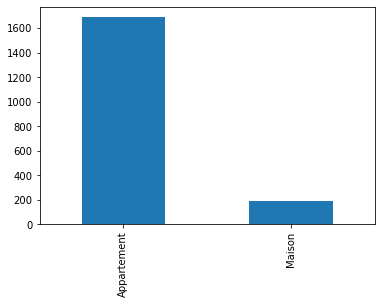

In [15]:
local_dataset = global_dataset.copy()
local_dataset['Type local'].value_counts().plot(kind='bar')

local_dataset = local_dataset[local_dataset['Type local'] == 'Appartement']

Le jeu possède essentiellement des appartements. Nous baserons principalement notre analyse sur ce type de biens.

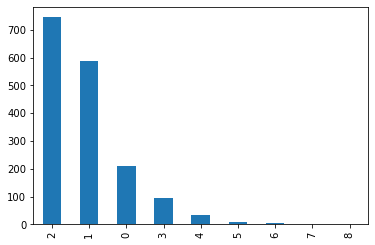

In [16]:
local_dataset['Nombre de lots'].value_counts().plot(kind='bar')

local_dataset = local_dataset[local_dataset['Nombre de lots'] == 1]

Nous avons majoritairement entre 0 et 3 lots. 

0 semble être une anomalie. Les différents lots où l'on trouve 2 ensemble doivent majoritairement correspondre au combo appartement + cave.

Pour le moment nous laisserons ces lots de côté. 

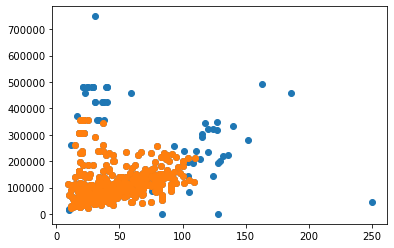

In [54]:
local_anomaly_dataset = local_dataset[['Valeur fonciere', 'Date mutation', 'Surface reelle bati', "Nombre pieces principales"]]

plt.scatter(local_anomaly_dataset['Surface reelle bati'], local_anomaly_dataset['Valeur fonciere'])

model = IsolationForest(contamination=float(0.1))
model.fit(local_anomaly_dataset[['Surface reelle bati', 'Valeur fonciere', "Nombre pieces principales"]])

local_anomaly_dataset['scores']=model.decision_function(local_anomaly_dataset[['Surface reelle bati', 'Valeur fonciere', "Nombre pieces principales"]])
local_anomaly_dataset['anomaly']=model.predict(local_anomaly_dataset[['Surface reelle bati', 'Valeur fonciere', "Nombre pieces principales"]])

local_anomaly_dataset[local_anomaly_dataset['anomaly'] == 1]

plt.scatter(local_anomaly_dataset[local_anomaly_dataset['anomaly'] == 1]['Surface reelle bati'], local_anomaly_dataset[local_anomaly_dataset['anomaly'] == 1]['Valeur fonciere'])

local_anomaly_dataset = local_anomaly_dataset[local_anomaly_dataset['anomaly'] == 1]
local_anomaly_dataset.drop(columns=['anomaly', 'scores'], inplace=True)